In [1]:
import monai
import numpy as np
import medmnist
import torch
from tqdm import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
train_dataset = medmnist.dataset.OrganMNIST3D(split="train", download=True, size=64)
val_dataset = medmnist.dataset.OrganMNIST3D(split="val", download=True, size=64)
test_dataset = medmnist.dataset.OrganMNIST3D(split="test", download=True, size=64)

Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz


In [3]:
test_dataset = val_dataset + test_dataset

In [4]:
label_map = {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}

In [5]:
train_dataset = monai.data.DatasetFunc(
    data=train_dataset,
    func=lambda dataset: [{'input': torch.tensor(item[0].astype(np.float32).transpose(0, 3, 2, 1)), 'target': torch.tensor(item[1][0])} for item in dataset]
)

test_dataset = monai.data.DatasetFunc(
    data=test_dataset,
    func=lambda dataset: [{'input': torch.tensor(item[0].astype(np.float32).transpose(0, 3, 2, 1)), 'target': torch.tensor(item[1][0])} for item in dataset]
)

In [6]:
import matplotlib.pyplot as plt

def plot_3d_image(ret):
    # Plot axial slice
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(ret[:, ret.shape[1] // 2, :, :].permute(1, 2, 0), cmap="gray")
    plt.title("Axial")
    plt.axis("off")

    # Plot sagittal slice
    plt.subplot(3, 1, 2)
    plt.imshow(ret[:, :, ret.shape[2] // 2, :].permute(1, 2, 0), cmap="gray")
    plt.title("Coronal")
    plt.axis("off")

    # Plot coronal slice
    plt.subplot(3, 1, 3)
    plt.imshow(ret[:, :, :, ret.shape[3] // 2].permute(1, 2, 0), cmap="gray")
    plt.title("Sagittal")

    plt.axis("off")
    plt.show()


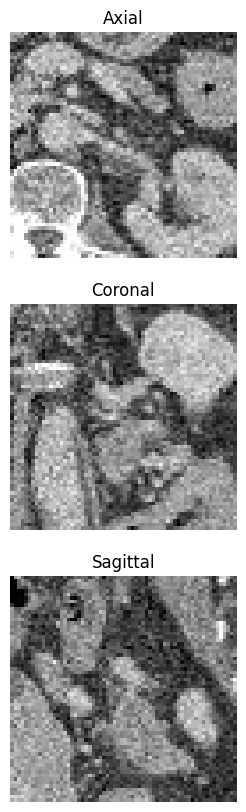

tensor(10)


In [7]:
idx = 26
plot_3d_image(test_dataset[idx]['input'])
print(test_dataset[idx]['target'])

In [8]:
import torch
from monai.networks.nets.segresnet_ds import SegResEncoder

weights = torch.load("/mnt/data1/CT_FM/latest_fm_checkpoints/pretrained_segresnet.torch", map_location=torch.device('cpu'))
weights = {k.replace('encoder.', ''): v for k, v in weights.items()}

ctfm_model = SegResEncoder(
    blocks_down=(1, 2, 2, 4, 4),
    head_module=lambda x: torch.nn.functional.adaptive_avg_pool3d(x[-1], 1).flatten(start_dim=1) # Get only the last feature across block levels and average pool it. 
)

ctfm_model = ctfm_model.to('cuda')
ctfm_model.load_state_dict(weights, strict=False) # Set strict to False as we load only the encoder
ctfm_model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


SegResEncoder(
  (conv_init): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (layers): ModuleList(
    (0): ModuleDict(
      (blocks): Sequential(
        (0): SegResBlock(
          (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
          (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (downsample): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    )
    (1): ModuleDict(
      (blocks): Sequential(
        (0): SegResBlock(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [9]:
import sys
sys.path.append('/home/suraj/Repositories/lighter-ct-fm')

from models.suprem import SuPreM_loader
from models.backbones.unet3d import UNet3D

suprem_model = torch.nn.Sequential(
SuPreM_loader(
    model=UNet3D(n_class=11),
    ckpt_path="/mnt/data1/CT_FM/baselines/SuPreM_UNet/supervised_suprem_unet_2100.pth",
    decoder=False,
    encoder_only=True,
    device=torch.device('cpu')
),
    torch.nn.AdaptiveAvgPool3d(1),
    torch.nn.Flatten(start_dim=1)
)

suprem_model = suprem_model.to('cuda')
suprem_model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading SuPreM UNet backbone pretrained weights
Loaded 56/106 keys


Sequential(
  (0): Encoder(
    (model): UNet3D(
      (down_tr64): DownTransition(
        (ops): Sequential(
          (0): LUConv(
            (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU(inplace=True)
          )
          (1): LUConv(
            (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU(inplace=True)
          )
        )
        (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (down_tr128): DownTransition(
        (ops): Sequential(
          (0): LUConv(
            (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(64,

In [33]:
len(train_dataset), len(test_dataset)

(971, 771)

In [10]:
train_dataloader = monai.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

test_dataloader = monai.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=False
)

In [11]:
train_dict = {
    "ct_fm":
        {
        "pred": [],
        "target": []
        },
    "suprem":
        {
        "pred": [],
        "target": []
        }
    }
    

test_dict = {
    "ct_fm":
        {
        "pred": [],
        "target": []
        },
    "suprem":
        {
        "pred": [],
        "target": []
        }
    }


for batch in train_dataloader:
    with torch.no_grad():
        batch['input'] = batch['input'].to('cuda')
        ct_fm_pred = ctfm_model(batch['input']).cpu().numpy()
        suprem_pred = suprem_model(batch['input']).cpu().numpy()

    train_dict['ct_fm']['pred'].extend(ct_fm_pred)
    train_dict['ct_fm']['target'].extend(batch['target'])
    train_dict['suprem']['pred'].extend(suprem_pred)
    train_dict['suprem']['target'].extend(batch['target'])


for batch in test_dataloader:
    with torch.no_grad():
        batch['input'] = batch['input'].to('cuda')
        ct_fm_pred = ctfm_model(batch['input']).cpu().numpy()
        suprem_pred = suprem_model(batch['input']).cpu().numpy()

    test_dict['ct_fm']['pred'].extend(ct_fm_pred)
    test_dict['ct_fm']['target'].extend(batch['target'])
    test_dict['suprem']['pred'].extend(suprem_pred)
    test_dict['suprem']['target'].extend(batch['target'])

In [12]:
import numpy as np
from itertools import product
from collections import Counter
#https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54#:~:text=Precision%20and%20recall%20at%20k%3A%20Definition&text=This%20means%20that%2080%25%20of,are%20relevant%20to%20the%20user.&text=Suppose%20that%20we%20computed%20recall,in%20the%20top%2Dk%20results.
#https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-1-per.pdf

# https://www.pinecone.io/learn/offline-evaluation/#Metrics-in-Information-Retrieval
# https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54
# https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Precision
# https://www.educative.io/answers/what-is-the-mean-average-precision-in-information-retrieval
def ap_k(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    Examples
    --------
    actual, predicted = ['a'], ['a', 'a', 'n', 'a', 'j']
    print(ap_k(actual, predicted, 5))   0.92
     """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual[:k]:
            # if p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return 0.0 if num_hits == 0.0 else score / num_hits


def map_k(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two list
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    -------
    example :
    actual, predicted = ['p_a', 'p_b'], [
                                        ['p_a', 'p_b', 'p_c', 'p_d', 'p_e', 'p_f'],
                                        ['p_c', 'p_d', 'p_e', 'p_f', 'p_a', 'p_b'],
                                        ['p_d', 'p_a', 'p_c', 'p_b', 'p_e', 'p_f'],
                                        ]
    print(map_k(actual, predicted, 6))
    actual, predicted = ['a'], [['a', 'b', 'a', 'c', 'a', 'c', 'a', 'c', 'c', 'b'],
                                ['c', 'b', 'a', 'v', 'a', 'c', 'a', 'v', 'v', 'v'],
                                ['a', 'x', 'a', 'c', 'a', 'x', 'x', 'c', 'c', 'v'],
                                ['a', 'x', 'a', 'x', 'x', 'c', 'x', 'c', 'c', 'b']]
    print(map_k(actual, predicted, 10))

    print(map_k([1], [[1,1,0,1,0]], k=5)) 0.916
    """
    return np.mean([ap_k(a, p, k) for a, p in product([actual], predicted)])


# is maybe hit_rate and mMV are similar ???
def hit_rate_k(actual, predicted, k=10):
    """
    example :
    actual, predicted = ['y'], ['y', 'y', 'n', 'y', 'n']
    print(hit_rate_k(actual, predicted, 5))
    """
    # hits = sum(predicted[i] in actual for i in range(k))
    # return hits / float(k)
    hits = any(predicted[i] in actual for i in range(k))
    return 1 if hits else 0

def acc_k(actual, predicted, acc_topk = 5):
    top_k_predictions = predicted[:acc_topk]

    hits = any(top_k_predictions[i] in actual for i in range(acc_topk))
    return 1 if hits else 0


def mMV_k_old(actual, predicted, k=10):
    """
    # Fast and Scalable Image Search For Histology
    # the mean majority vote == mMV_k
    the majority top-5 accuracy
    Returns:
    list: The class label with the majority vote for each prediction.
    example:
    actual, predicted = ['w'], ['w','jj','ss','eee','w']
    print(mMV_k(actual, predicted, k=5)) 1
    """
    # for pred in predicted:
    top_k_predictions = predicted[:k]
    top_k_predictions_numbers = [int(pred[0]) for pred in top_k_predictions]
    vote_count = Counter(top_k_predictions_numbers)
    majority_vote = vote_count.most_common(1)[0][0]
    #     mmv_results.append(majority_vote)
    # word_counts = Counter(mmv_results)
    # most_common_word = word_counts.most_common(1)[0][1]
    # return most_common_word/len(predicted)
    return 1 if majority_vote in actual else 0


def mMV_k(actual, predicted, k=10):
    top_k_predictions = predicted[:k]
    top_k_predictions_numbers = [int(pred[0]) for pred in top_k_predictions]
    vote_count = Counter(top_k_predictions_numbers)
    max_votes = max(vote_count.values())
    tied_majorities = [prediction for prediction, votes in vote_count.items() if votes == max_votes]
    for majority_vote in tied_majorities:
        if majority_vote in actual:
            return 1
    return 0



In [13]:
len(test_dataset)

771

In [18]:
import plotly.graph_objects as go

results = {}
k_values = [3, 5, 10]

for model, tensors in test_dict.items():
    results[model] = {}
    for k in k_values:
        metric_dict = {
            f"AP@{k}": [],
            f"HR@{k}": [],
            f"F1@{k}": []
        }
        for i in tqdm(range(len(tensors["pred"]))):
            query = tensors["pred"][i]
            label = tensors["target"][i]

            retrieved = []
            for j in range(len(train_dict[model]["pred"])):
                retrieved.append((np.linalg.norm(query - train_dict[model]["pred"][j]), train_dict[model]["target"][j]))

            retrieved.sort(key=lambda x: x[0])

            retrieved = retrieved[:k]
            retrieved_labels = [x[1].item() for x in retrieved]

            ap_k_idx = ap_k([label.item()], retrieved_labels, k=k)
            hr_k_idx = hit_rate_k([label.item()], retrieved_labels, k=k)

            f1_score = 2 * (ap_k_idx * hr_k_idx) / (ap_k_idx + hr_k_idx) if (ap_k_idx + hr_k_idx) > 0 else 0

            metric_dict[f"AP@{k}"].append(ap_k_idx)
            metric_dict[f"HR@{k}"].append(hr_k_idx)
            metric_dict[f"F1@{k}"].append(f1_score)

        res_dict = {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        results[model][k] = res_dict
        print(f"Model: {model}, k={k}")
        print("Results:")
        for key, value in res_dict.items():
            print(f"{key}: {value:.4f}")
        print()

# Prepare data for plotting
models = list(results.keys())
metrics = [f"{metric}@{k}" for k in k_values for metric in ["AP", "HR", "F1"]]


100%|██████████| 771/771 [00:03<00:00, 207.41it/s]


Model: ct_fm, k=3
Results:
AP@3: 0.9319
HR@3: 0.9676
F1@3: 0.9444



100%|██████████| 771/771 [00:04<00:00, 165.91it/s]


Model: ct_fm, k=5
Results:
AP@5: 0.9257
HR@5: 0.9792
F1@5: 0.9444



100%|██████████| 771/771 [00:03<00:00, 214.00it/s]


Model: ct_fm, k=10
Results:
AP@10: 0.9054
HR@10: 0.9909
F1@10: 0.9352



100%|██████████| 771/771 [00:03<00:00, 214.91it/s]


Model: suprem, k=3
Results:
AP@3: 0.9229
HR@3: 0.9585
F1@3: 0.9347



100%|██████████| 771/771 [00:03<00:00, 203.40it/s]


Model: suprem, k=5
Results:
AP@5: 0.9145
HR@5: 0.9715
F1@5: 0.9341



100%|██████████| 771/771 [00:04<00:00, 173.56it/s]

Model: suprem, k=10
Results:
AP@10: 0.8928
HR@10: 0.9896
F1@10: 0.9261



In [19]:
results

{'ct_fm': {3: {'AP@3': 0.9319066147859922,
   'HR@3': 0.9675745784695201,
   'F1@3': 0.9443679059693806},
  5: {'AP@5': 0.9257151606859778,
   'HR@5': 0.9792477302204928,
   'F1@5': 0.9443812050316327},
  10: {'AP@10': 0.9054156007289307,
   'HR@10': 0.9909208819714657,
   'F1@10': 0.9352327625036927}},
 'suprem': {3: {'AP@3': 0.9229355814958928,
   'HR@3': 0.9584954604409858,
   'F1@3': 0.9347261267187542},
  5: {'AP@5': 0.9144581351779796,
   'HR@5': 0.9714656290531777,
   'F1@5': 0.9341350763028788},
  10: {'AP@10': 0.8928288711002487,
   'HR@10': 0.9896238651102465,
   'F1@10': 0.9260803506630448}}}

In [32]:
import plotly.graph_objects as go
import pandas as pd

# Prepare data
data = []
for model in results:
    for k in [3, 5, 10]:
        for metric in ['AP', 'HR', 'F1']:
            data.append({
                'Model': 'CT-FM' if model == 'ct_fm' else 'Baseline',
                'K': f'K={k}',
                'Metric': metric,
                'Score': results[model][k][f'{metric}@{k}']
            })

df = pd.DataFrame(data)

# Colors for each model
colors = {'CT-FM': '#0B559F', 'Baseline': 'gray'}

# Create separate figures for each metric
for metric in ['AP', 'HR', 'F1']:
    fig = go.Figure()
    
    for model in ['CT-FM', 'Baseline']:
        df_model = df[(df['Model'] == model) & (df['Metric'] == metric)]
        fig.add_trace(
            go.Bar(
                x=df_model['K'],
                y=df_model['Score'],
                name=model,
                marker_color=colors[model],
                text=df_model['Score'].round(2),
                textposition='inside',
                textfont=dict(color='white')
            )
        )

    # Update layout
    fig.update_layout(
        title=f'{metric} Performance Comparison',
        xaxis_title='K',
        yaxis_title='Score',
        barmode='group',
        plot_bgcolor='white',
        font_size=20,
        height=600,
        width=600,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    # Update axes
    fig.update_yaxes(range=[0.8, 1])
    fig.update_xaxes(type='category')

    fig.show()